In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2
import mediapipe as mp
from keras.preprocessing import image
import imutils
from imutils.video import FPS

In [2]:
x, y = pkl.load(open('C:/Users/Admin/Downloads/samples.pkl/datasetAI.pkl', 'rb'))
print(x.shape, y.shape)
roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

print(roll.min(), roll.max(), roll.mean(), roll.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6288, 2278) (6288, 3)
-46.06486893 43.00866699 -0.52579503197042 5.176231116713095
-29.88856888 34.09674835 2.584682740273537 7.962828151857226
-75.55059814 86.84925079 -0.11620588007315523 13.090839183150852
(4401, 2278) (4401, 3)
(943, 2278) (943, 3)
(944, 2278) (944, 3)


In [3]:
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

In [4]:
BATCH_SIZE = 64
EPOCHS = 100

In [5]:

model = Sequential()
model.add(Dense(units=20, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(units=10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(units=3, activation='linear'))

print(model.summary())

callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callback_list)
model.save('models/modelface.h5')

print()
print('Train loss:', model.evaluate(x_train, y_train, verbose=0))
print('  Val loss:', model.evaluate(x_val, y_val, verbose=0))
print(' Test loss:', model.evaluate(x_test, y_test, verbose=0))

history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                45580     
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 45,823
Trainable params: 45,823
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
69/69 [==============================] - 1s 3ms/step - loss: 64.8810 - val_loss: 49.5218
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 45.4942 - val_loss: 42.5604
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 41.5061 - val_loss: 41.7536
Epoch 4/

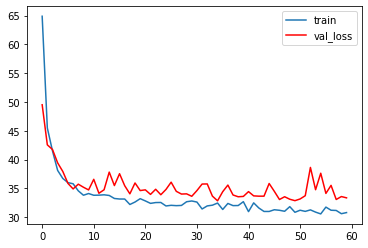

In [6]:
history = hist.history
loss_train = history['loss']
loss_val = history['val_loss']

plt.figure()
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val_loss', color='red')
plt.legend()

30/30 [==============================] - 0s 621us/step


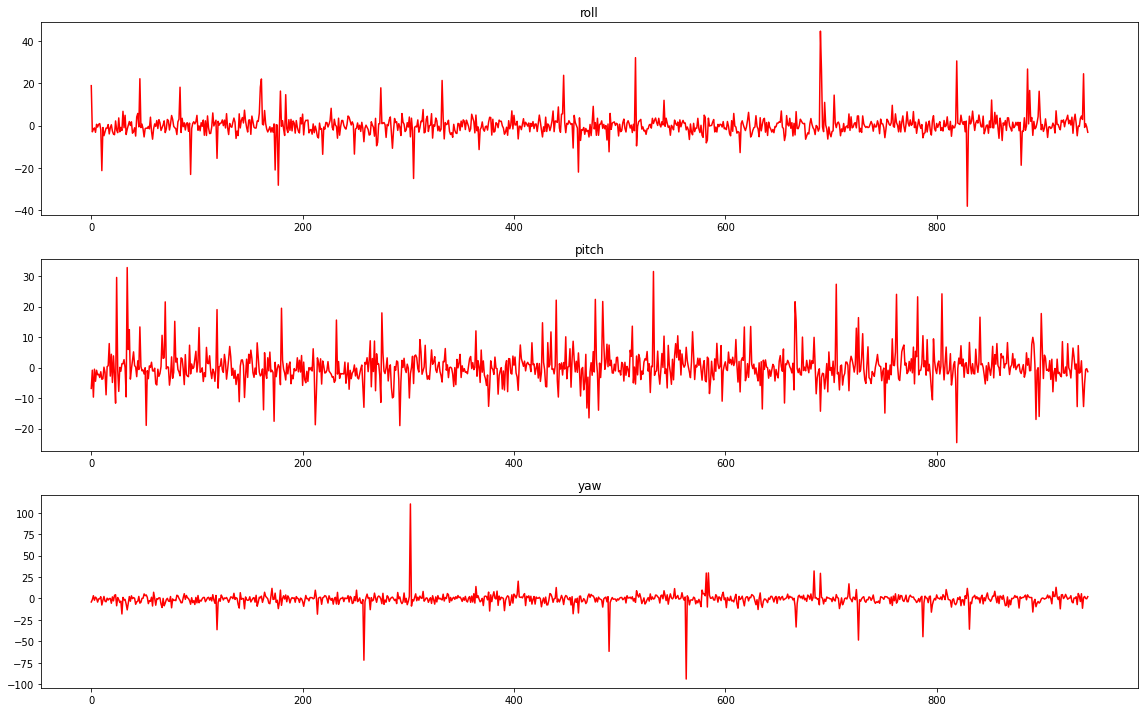

In [7]:
y_pred = model.predict(x_test)
diff = y_test - y_pred
diff_roll = diff[:, 0]
diff_pitch = diff[:, 1]
diff_yaw = diff[:, 2]

plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(diff_roll, color='red')
plt.title('roll')

plt.subplot(3, 1, 2)
plt.plot(diff_pitch, color='red')
plt.title('pitch')

plt.subplot(3, 1, 3)
plt.plot(diff_yaw, color='red')
plt.title('yaw')

plt.tight_layout()

In [10]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("C:/Users/Admin/Downloads/data.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = predictor(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))
            
    return np.array(features).reshape(1, -1)

1/1 [==============================] - 0s 203ms/step
 Z: -1.82°
X: 31.03°
  Y: -27.07°


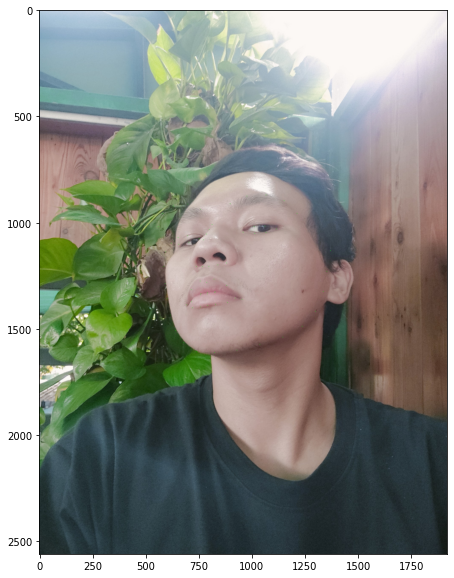

In [6]:
image = cv2.imread('C:/Users/Admin/Downloads/eeb76462bff67fa826e7.JPG', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(image)

for x, y in face_points:
    cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)

model = load_model('models/modelface.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' Z: {:.2f}°'.format(roll_pred))
print('X: {:.2f}°'.format(pitch_pred))
print('  Y: {:.2f}°'.format(yaw_pred))

plt.figure(figsize=(10, 10))
plt.imshow(image)

In [11]:
cap = cv2.VideoCapture(0)
model = load_model('C:/Users/Admin/Desktop/models/modelface.h5')
while(True):
    success, image = cap.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.flip(image,1)
    face_points = detect_face_points(image)
    for x, y in face_points:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    features = compute_features(face_points)
    y_pred = model.predict(features)
    roll_pred, pitch_pred, yaw_pred = y_pred[0]
    print(' Z: {:.2f}°'.format(roll_pred))
    print('X: {:.2f}°'.format(pitch_pred))
    print('  Y: {:.2f}°'.format(yaw_pred))
    if yaw_pred < -350:
        text = "Nhin ben trai"
    elif yaw_pred > 350:
        text = "Nhin ben phai"
    elif pitch_pred < -150:
        text = "Nhin xuong duoi"
    elif pitch_pred>150 :
        text = "Nhin len tren"
    elif roll_pred>-150 :
        text = "Nghieng phai"
    elif roll_pred<-260:
        text = "Nghieng trai"
    
    else:
        text = "Nhin thang"
    cv2.putText(image,"Huong nhin:" ,(100,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(image, text, (300, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(image, 'X:'+str(np.round(pitch_pred,2)),(460,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(image, "Y:"+str(np.round(yaw_pred,2)),(460,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(image, "Z:"+str(np.round(roll_pred,2)),(460,250), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(image, "Goc Quay:",(460,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('GOC XOAY KHUON MAT', image)
          
    if cv2.waitKey(1) & 0xFF == ord('q'):
         break
    
cap.release()
# Destroy all the windows
cv2.destroyAllWindows()
    




AssertionError: len(face_points) must be 68